Import libraries

In [1]:
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings('ignore')

Define train and test datasets

In [2]:
trainData = datasets.MNIST(root='data', train= True, download= True, transform= ToTensor())

In [3]:
testData = datasets.MNIST(root='data', train= False, download= True, transform= ToTensor())

In [4]:
print(f"{testData} \n\n {trainData}")

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor() 

 Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


Define loaders

In [5]:
trainLoader = torch.utils.data.DataLoader(trainData, batch_size= 64, shuffle= True)
testLoader = torch.utils.data.DataLoader(testData, batch_size= 100, shuffle=True)

Convolutional Neural Network

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convLayer1 = nn.Conv2d(in_channels= 1, out_channels= 10, kernel_size=5)
        self.convLayer2 = nn.Conv2d(in_channels= 10, out_channels= 20,kernel_size=5)
        self.conv2Drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.convLayer1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2Drop(self.convLayer2(x)), 2))
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x,training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x)

Use GPU if possible

In [7]:

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Currently used device: {device}")

Currently used device: mps


In [8]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
calcLoss = nn.CrossEntropyLoss()

Define train function

In [9]:
def train(epoch):
    model.train()
    for (data, target) in trainLoader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = calcLoss(output, target)
        loss.backward()
        optimizer.step()

Define test function

In [36]:
correctVals = []
predcitedVals = []

def test():
    model.eval()
    testLoss = 0
    correctVal = 0

    with torch.no_grad():
        for data, target in testLoader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            testLoss += F.nll_loss(input= output, target= target, size_average=False).item()
            prediction = output.data.max(1, keepdim=True)[1]
            correctVal += prediction.eq(target.data.view_as(prediction)).sum()
            correctVals.extend(target.tolist())
            predcitedVals.extend(prediction.tolist())
            accuracy = correctVal / len(testLoader.dataset)

    testLoss /= len(testLoader.dataset)
    print(f"Average loss: {testLoss:.4f}, accuracy {correctVal}/{len(testLoader.dataset)} ({(100. * accuracy):.0f}%)\n")
            

Train network

In [ ]:
for epoch in range(1, 10):
    train(epoch)
    test()

Define function to plot confusion matrix

In [38]:
def plotConfusionMatrix(confusionMatrix):
    classes = range(10)
    plt.figure(figsize=(8, 8))
    plt.imshow(confusionMatrix,
               interpolation='nearest',
               cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tickMarks = np.arange(len(classes))
    plt.xticks(tickMarks, classes, rotation=45)
    plt.yticks(tickMarks, classes)

    thresh = confusionMatrix.max() / 2.
    for i, j in itertools.product(range(confusionMatrix.shape[0]), range(confusionMatrix.shape[1])):
        plt.text(j, i, confusionMatrix[i, j],
                 horizontalalignment="center",
                 color="white" if confusionMatrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True")
    plt.xlabel("Predicted")

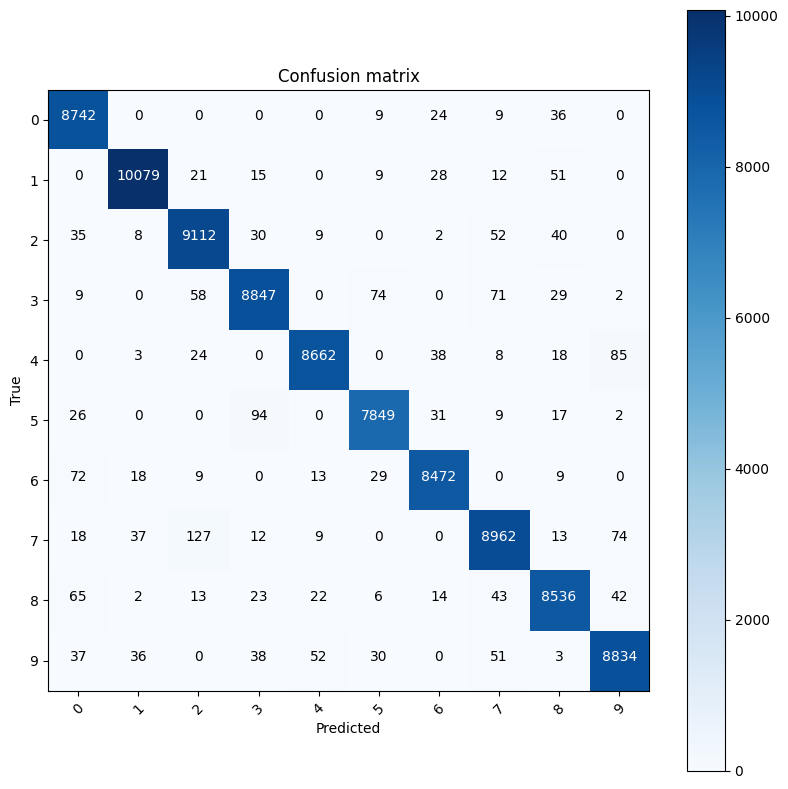

In [40]:
confusionMatrix = confusion_matrix(correctVals, predcitedVals)
plotConfusionMatrix(confusionMatrix)

In [ ]:

def preProcess(img):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ])
    return transform(img)


cap = cv2.VideoCapture(0)
cap.set(3, 480)
cap.set(4, 480)

while True:
    _, frame = cap.read()
    if _:
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img = preProcess(img)
        img = img.unsqueeze(0)
        img = img.unsqueeze(0)

        with torch.no_grad():
            outputs = model(img)
            model.eval()
            _, predicted = torch.max(outputs, 1)
            probVal = torch.nn.functional.softmax(
                outputs, dim=1)[0][predicted].item()
            classIndex = predicted.item()
            print(classIndex, probVal)

            if probVal > 0.7:
                cv2.putText(frame, str(classIndex) + "  " + str(probVal),
                            (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1)

            cv2.imshow("digit-recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break